In [39]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(42)
numBins=5
numSamples=200
bins=np.linspace(0.0,1.0,numBins)
x=np.random.random_sample(numSamples)
y=np.random.random_sample(numSamples)
vx=np.random.random_sample(numSamples)
vy=np.random.random_sample(numSamples)
# plt.scatter(x,y)
# for bin in bins:
#     plt.axvline(x=bin)
#     plt.axhline(y=bin)
# plt.show()
t=time.time()
edgex=np.digitize(x,bins)
edgey=np.digitize(y,bins)
sortIndicesx=np.argsort(edgex)
edgexSorted=edgex[sortIndicesx]
edgeySorted=edgey[sortIndicesx]
np.unique(edgexSorted,return_counts=True)[1]
print(10_000*(time.time()-t)/3600)

0.03996358977423774


In [45]:
sortIndicesx=np.argsort(edgex)
edgexSorted=edgex[sortIndicesx]
edgeySorted=edgey[sortIndicesx]
splitIndicesx=np.cumsum(np.unique(edgexSorted,return_counts=True)[1])
edgexSplit=np.split(edgexSorted,splitIndicesx)
edgexySplit=np.split(edgeySorted,splitIndicesx)
edgexySplit

[array([1, 4, 2, 1, 3, 4, 4, 1, 4, 4, 2, 4, 2, 4, 3, 3, 1, 1, 2, 4, 3, 4,
        2, 1, 4, 4, 3, 1, 3, 4, 3, 3, 1, 1, 3, 1, 3, 1, 3, 2, 3, 1, 1, 4,
        3, 4, 2, 3, 3, 3, 4, 4, 3, 4, 1, 4]),
 array([1, 3, 4, 2, 3, 3, 1, 3, 1, 1, 1, 3, 2, 2, 3, 1, 2, 3, 2, 1, 4, 2,
        3, 3, 2, 1, 2, 3, 1, 2, 4, 1, 1, 2, 3, 4, 3, 2, 2, 2, 1, 4, 3, 4,
        2, 3]),
 array([1, 4, 3, 4, 4, 1, 4, 3, 3, 4, 1, 4, 4, 4, 1, 2, 3, 3, 2, 1, 3, 4,
        1, 1, 4, 3, 1, 1, 3, 1, 4, 2, 3, 4, 3, 3, 4, 4, 3, 2, 2, 1, 1, 3,
        1, 2, 3]),
 array([4, 2, 4, 4, 4, 4, 1, 3, 4, 3, 1, 2, 3, 2, 2, 4, 2, 2, 3, 4, 1, 3,
        2, 2, 4, 1, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 2, 1, 1, 2, 3, 3, 1,
        4, 1, 1, 2, 2, 3, 4]),
 array([], dtype=int64)]

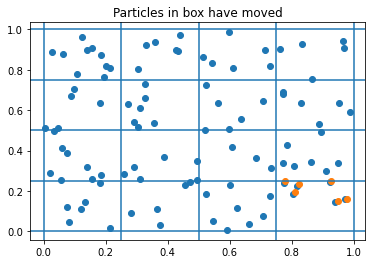

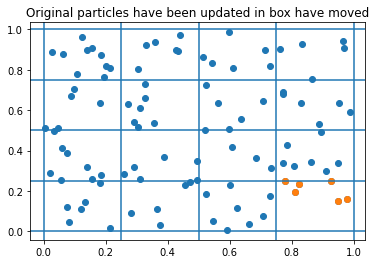

In [54]:
edgex=np.digitize(x,bins)
edgey=np.digitize(y,bins)
boxLoc=(4,1)
def func(c):
assert 1<=boxLoc[0]<=numBins and 1<=boxLoc[1]<=numBins
subIndices=np.logical_and(edgex==boxLoc[0],edgey==boxLoc[1])
xSub=x[subIndices]
ySub=y[subIndices]
vxSub=vx[subIndices]
vySub=vy[subIndices]

xSub=xSub+vxSub*1e-2
ySub=ySub+vySub*1e-2
plt.title("Particles in box have moved")
plt.scatter(x,y)
plt.scatter(xSub,ySub) #new positions
for bin in bins:
    plt.axvline(x=bin)
    plt.axhline(y=bin)
plt.show()
x[subIndices]=xSub #update the old coorinates
y[subIndices]=ySub
plt.title("Original particles have been updated in box have moved")
plt.scatter(x,y)
plt.scatter(xSub,ySub) #new positions
for bin in bins:
    plt.axvline(x=bin)
    plt.axhline(y=bin)
plt.show()

In [64]:
data=np.loadtxt('run2_1Shim')
data=data[data[:,-1]!=np.inf]
data=data[1:]
costArr=data[:,-1]
iterArr=np.arange(0,len(data))
convergenceList=[[0,costArr[0]]]
for cost,iter in zip(costArr[1:],iterArr[1:]):
    if cost<=convergenceList[-1][1]:
        convergenceList.append([iter,cost])

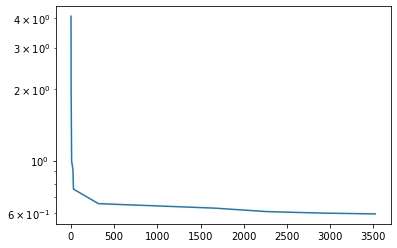

In [65]:
temp=np.asarray(convergenceList)
plt.semilogy(temp[:,0],temp[:,1])
plt.show()

In [66]:
data[-10:]

array([[0.19746456, 0.07511526, 0.04349363, 1.72572043, 5.79028421,
        0.02483248, 0.43701566, 0.70113817],
       [0.19469608, 0.07522632, 0.03777984, 1.57904376, 4.99147148,
        0.02536473, 0.4710559 , 0.63939847],
       [0.18832677, 0.0754    , 0.02912778, 1.43089294, 5.85092848,
        0.0254    , 0.4601138 , 0.82092089],
       [0.19452216, 0.07484608, 0.03157547, 1.73211249, 5.44928351,
        0.0254    , 0.37936933, 0.64835293],
       [0.19694147, 0.0754    , 0.03697711, 1.52672999, 5.92380031,
        0.02469416, 0.43366319, 0.68625176],
       [0.19755305, 0.0754    , 0.03998771, 1.60771382, 4.64595499,
        0.02536473, 0.42911112, 0.70066236],
       [0.18938001, 0.07399173, 0.03254534, 1.51023123, 4.79733354,
        0.0254    , 0.41991216, 0.67810099],
       [0.18714489, 0.07488633, 0.03930175, 1.64761685, 4.45941503,
        0.0254    , 0.35227568, 0.89596641],
       [0.18769006, 0.0741476 , 0.04413567, 1.57248473, 5.18980792,
        0.0254    , 0.455534